# Example on the urban canopy data 

In [1]:
from pivpy import io, graphics, pivpy
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pkg_resources as pkg
%matplotlib inline

In [2]:
from lvreader import read_buffer
from lvreader.frame import VectorFrame
from lvreader.plot import plot_vector_field, prettify_plot
# import pathlib
# vc7file = pathlib.Path('../../pivpy/data/VC7/2d2c/2Ca.vc7')
buffer = read_buffer(pkg.resource_filename('pivpy','data/urban_canopy/B00001.vc7'))
# print(buffer)

0.0 16 Scale(slope=0.0806436, offset=-77.0953, unit='mm', description='position') -77.0953
160.0 16 Scale(slope=0.0806436, offset=-77.0953, unit='mm', description='position') 129.35231599999997
0.0 16 Scale(slope=-0.0806436, offset=177.401, unit='mm', description='position') 177.401
135.0 16 Scale(slope=-0.0806436, offset=177.401, unit='mm', description='position') 3.2108240000000308
0.0 16 Scale(slope=0.0806436, offset=-77.0953, unit='mm', description='position') -77.0953
160.0 16 Scale(slope=0.0806436, offset=-77.0953, unit='mm', description='position') 129.35231599999997
0.0 16 Scale(slope=0.0806436, offset=-77.0953, unit='mm', description='position') -77.0953
160.0 16 Scale(slope=0.0806436, offset=-77.0953, unit='mm', description='position') 129.35231599999997
0.0 16 Scale(slope=-0.0806436, offset=177.401, unit='mm', description='position') 177.401
135.0 16 Scale(slope=-0.0806436, offset=177.401, unit='mm', description='position') 3.2108240000000308
0.0 16 Scale(slope=-0.0806436, o

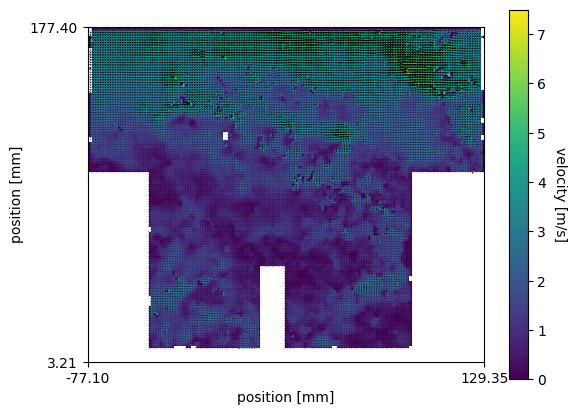

In [36]:
buffer.plot()

In [4]:
data = buffer[0]
data.shape, data.scales, data.enabled, data.grid

((135, 160),
 Scales(x=Scale(slope=0.0806436, offset=-77.0953, unit='mm', description='position'), y=Scale(slope=-0.0806436, offset=177.401, unit='mm', description='position'), z=Scale(slope=1.0, offset=0.0, unit='pixel', description=''), i=Scale(slope=0.268812, offset=0.0, unit='m/s', description='velocity')),
 [array([[0, 1, 1, ..., 1, 1, 0],
         [1, 1, 1, ..., 1, 1, 0],
         [1, 1, 1, ..., 1, 1, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)],
 Grid(x=16, y=16, z=16))

In [5]:
plane = 0


In [6]:
data.grid.x

16

In [7]:

u = data.components["U0"][plane]
v = data.components["V0"][plane]

In [8]:
mask = np.logical_not(data.masks[plane] & data.enabled[plane])
# We can't just leave arbitrary values in masked areas, or they would
# produce overflow warnings and invalid value warnings during plotting:
u[mask] = 0.0
v[mask] = 0.0
# mask.harden_mask()

# scale
u = data.scales.i.offset + u*data.scales.i.slope
v = data.scales.i.offset + v*data.scales.i.slope



In [9]:
x = np.arange(u.shape[0])
y = np.arange(u.shape[1])

print(x.min(), x.max(), y.min(), y.max())

x = data.scales.x.offset + (x+.5)*data.scales.x.slope*data.grid.x
y = data.scales.y.offset + (y+.5)*data.scales.y.slope*data.grid.y

x,y = np.meshgrid(x,y)

0 134 0 159


In [10]:
print(x.min(), x.max(), y.min(), y.max())

-76.4501512 96.4497272 -28.401467199999985 176.75585120000002


In [11]:
from pivpy import io, graphics, pivpy
import xarray as xr

ds = io.from_arrays(x,y,u.T,v.T,mask.T)

ds

<xarray.Dataset>
Dimensions:  (x: 135, y: 160, t: 1)
Coordinates:
  * x        (x) float64 -76.45 -75.16 -73.87 -72.58 ... 92.58 93.87 95.16 96.45
  * y        (y) float64 176.8 175.5 174.2 172.9 ... -24.53 -25.82 -27.11 -28.4
  * t        (t) int64 0
Data variables:
    u        (x, y, t) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    v        (x, y, t) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    chc      (x, y, t) bool True False False False False ... True True True True
Attributes: (2)

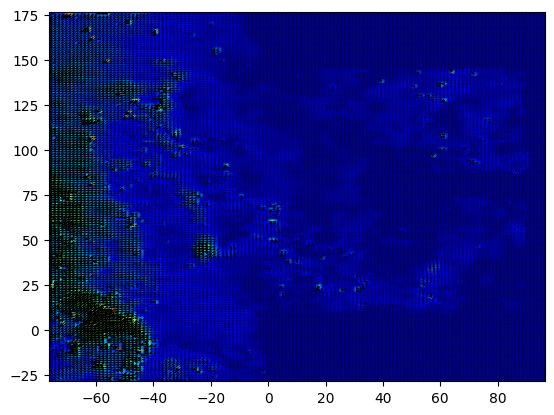

In [35]:
fig, ax = plt.subplots()

# ds.piv.vorticity() # add vorticity
ds.piv.kinetic_energy()

ax.pcolormesh(ds.x, ds.y, ds.w[:,:,0].T,shading='gouraud',cmap='jet')
ax.quiver(ds.x, ds.y, ds.u[:,:,0].T, ds.v[:,:,0].T)


In [15]:

ax.imshow(ds["w"])

In [16]:
# if we need to mask
# np.ma.array(u,mask = mask)

/tmp/ipykernel_910114/466728873.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([x.min(), x.max()])
/tmp/ipykernel_910114/466728873.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([y.max(), y.min()])


[Text(0, -0.5, '176.75585120000002'), Text(0, 134.5, '-28.401467199999985')]

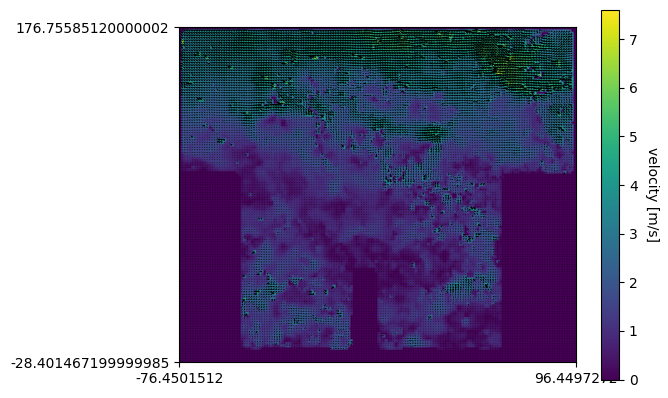

In [17]:
# scale first
# self.scales.i.offset + values * self.scales.i.slope
# u = scale(u)
#  



background = np.sqrt(u * u + v * v)

fig, ax = plt.subplots()
image = ax.imshow(background)
ax.quiver(u, v, angles='xy', width=0.002)

colorbar = fig.colorbar(image)
colorbar.ax.yaxis.labelpad = 15
colorbar.ax.set_ylabel(data.scales.i.label(), rotation=270)


from matplotlib.ticker import FuncFormatter, LinearLocator

ax.xaxis.set_major_locator(LinearLocator(2))    
ax.yaxis.set_major_locator(LinearLocator(2))

ax.set_xticklabels([x.min(), x.max()])
ax.set_yticklabels([y.max(), y.min()])



In [18]:
def scaled_coordinate(value, axis, scales, grids):
    # we want 0 to be top left edge, not center of top left pixel/vector:
    corrected = value + 0.5
    grid = 1 if grids is None else getattr(grids, axis)
    scale = getattr(scales, axis)
    return corrected * grid * scale.slope + scale.offset

In [19]:
def prettify_plot(fig, scales, grids=None):
    """
    Adorns a given figure with labels and a color bar.
    Also sets exactly two ticks on each axis (one at each end)
    to make the data range clearly visible, and rounds their labels
    if possible without them becoming indistinguishable.
    """
    from matplotlib.ticker import FuncFormatter, LinearLocator

    [ax] = fig.axes
    ax.xaxis.set_major_locator(LinearLocator(2))
    ax.yaxis.set_major_locator(LinearLocator(2))

    def make_formatter(axis, *, rounded):
        @FuncFormatter
        def formatter(value, _=None):
            scaled = scaled_coordinate(value, axis, scales, grids)
            return f"{scaled:.2f}" if rounded else f"{scaled}"
        return formatter

    def determine_suitable_formatter(axis):
        if axis == "x":
            ticks = ax.get_xticks()
        else:
            ticks = ax.get_yticks()
        first, last = ticks  # we expect there to be exactly two ticks
        # if ticks have same label after rounding, then don't round
        formatter = make_formatter(axis, rounded=True)
        if formatter(first) == formatter(last):
            formatter = make_formatter(axis, rounded=False)
        return formatter

    ax.xaxis.set_major_formatter(determine_suitable_formatter("x"))
    ax.yaxis.set_major_formatter(determine_suitable_formatter("y"))

    ax.set_xlabel(scales.x.label())
    ax.set_ylabel(scales.y.label())

    [image] = ax.images
    colorbar = fig.colorbar(image)
    colorbar.ax.yaxis.labelpad = 15
    colorbar.ax.set_ylabel(scales.i.label(), rotation=270)


def plot_image(data, scales, *, show=True):
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots()
    ax.imshow(data)

    prettify_plot(fig, scales)

    if show:
        plt.show()
    else:
        return fig


In [20]:
def plot_vector_field(uvw_unscaled, uvw_scaled, is_3c, scales, grids, *, show=True):
    import matplotlib.pyplot as plt

    u = uvw_scaled["u"]
    v = uvw_scaled["v"]
    if is_3c:
        w = uvw_scaled["w"]

    if is_3c:
        background = np.ma.sqrt(u * u + v * v + w * w)
    else:
        background = np.ma.sqrt(u * u + v * v)

    fig, ax = plt.subplots()
    ax.imshow(background)
    ax.quiver(uvw_unscaled["u"], uvw_unscaled["v"], angles='xy', width=0.002)

    prettify_plot(fig, scales, grids)

    if show:
        plt.show()
    else:
        return fig

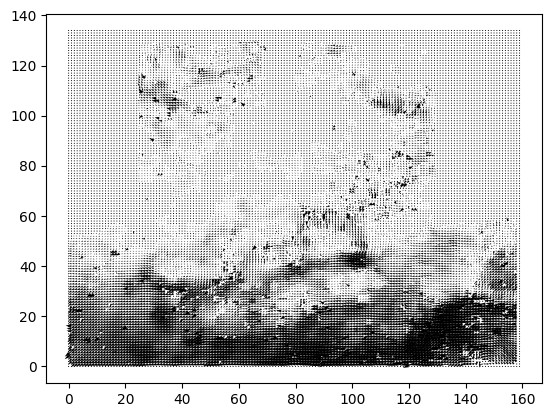

In [21]:
plt.figure()
plt.quiver(data.components['U0'][0], data.components['V0'][0])

In [22]:
getattr(data.scales, 'x'), getattr(data.scales, 'y')

(Scale(slope=0.0806436, offset=-77.0953, unit='mm', description='position'),
 Scale(slope=-0.0806436, offset=177.401, unit='mm', description='position'))

In [23]:
def _scale_masked_array_in_place(arr) -> None:
    u = arr["u"]
    v = arr["v"]
    u[:] = arr._scaled_intensity(u) * np.sign(arr.scales.x.slope)
    v[:] = arr._scaled_intensity(v) * np.sign(arr.scales.y.slope)
    if self.is_3c:
        w = arr["w"]
        w[:] = arr._scaled_intensity(w) * np.sign(arr.scales.z.slope)

In [24]:
plot_vector_field(
    unscaled,
    scaled,
    data.is_3c,
    data.scales,
    data.grid,
    show=True
)

NameError: name 'unscaled' is not defined

In [ ]:
unscaled = data._as_unscaled_masked_array(plane)
scaled = unscaled.copy()
_scale_masked_array_in_place(scaled)


AttributeError: 'MaskedArray' object has no attribute '_scaled_intensity'

In [ ]:
def plot_vector_field(uvw_unscaled, uvw_scaled, is_3c, scales, grids, *, show=True):
    import matplotlib.pyplot as plt

    u = uvw_scaled["u"]
    v = uvw_scaled["v"]
    if is_3c:
        w = uvw_scaled["w"]

    if is_3c:
        background = np.ma.sqrt(u * u + v * v + w * w)
    else:
        background = np.ma.sqrt(u * u + v * v)

    fig, ax = plt.subplots()
    ax.imshow(background)
    ax.quiver(uvw_unscaled["u"], uvw_unscaled["v"], angles='xy', width=0.002)

    prettify_plot(fig, scales, grids)

    if show:
        plt.show()
    else:
        return fig

In [ ]:
def scaled_coordinate(value, axis, scales, grids):
    # we want 0 to be top left edge, not center of top left pixel/vector:
    corrected = value + 0.5
    grid = 1 if grids is None else getattr(grids, axis)
    scale = getattr(scales, axis)
    return corrected * grid * scale.slope + scale.offset

In [ ]:
def prettify_plot(fig, scales, grids=None):
    """
    Adorns a given figure with labels and a color bar.
    Also sets exactly two ticks on each axis (one at each end)
    to make the data range clearly visible, and rounds their labels
    if possible without them becoming indistinguishable.
    """
    from matplotlib.ticker import FuncFormatter, LinearLocator

    [ax] = fig.axes
    ax.xaxis.set_major_locator(LinearLocator(2))
    ax.yaxis.set_major_locator(LinearLocator(2))

    def make_formatter(axis, *, rounded):
        @FuncFormatter
        def formatter(value, _=None):
            scaled = scaled_coordinate(value, axis, scales, grids)
            return f"{scaled:.2f}" if rounded else f"{scaled}"
        return formatter

    def determine_suitable_formatter(axis):
        if axis == "x":
            ticks = ax.get_xticks()
        else:
            ticks = ax.get_yticks()
        first, last = ticks  # we expect there to be exactly two ticks
        # if ticks have same label after rounding, then don't round
        formatter = make_formatter(axis, rounded=True)
        if formatter(first) == formatter(last):
            formatter = make_formatter(axis, rounded=False)
        return formatter

    ax.xaxis.set_major_formatter(determine_suitable_formatter("x"))
    ax.yaxis.set_major_formatter(determine_suitable_formatter("y"))

    ax.set_xlabel(scales.x.label())
    ax.set_ylabel(scales.y.label())

    [image] = ax.images
    colorbar = fig.colorbar(image)
    colorbar.ax.yaxis.labelpad = 15
    colorbar.ax.set_ylabel(scales.i.label(), rotation=270)

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='x(mm)', ylabel='y (mm)'>)

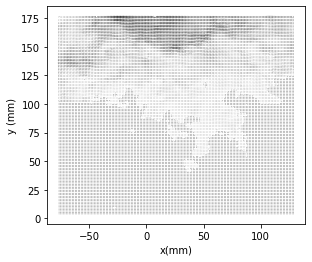

In [ ]:
graphics.quiver(data.isel(t=-1),arrScale=100) # show last

In [ ]:
# let's try a vertical profile

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='x(mm)', ylabel='y (mm)'>)

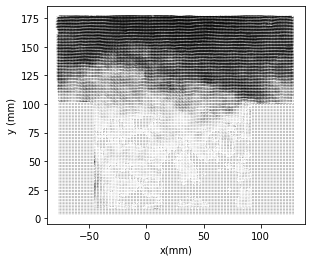

In [ ]:
graphics.quiver(data.piv.average,arrScale=50)

Text(0, 0.5, 'z (mm)')

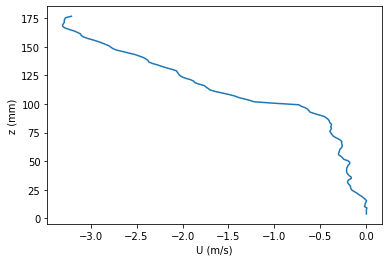

In [ ]:
# Let's try vertical profile of streamwise mean velocity U(z)
# we could define it a shortcut of the type:
# graphics.profile(velocity_component = 'u', coordinate = 'z') 
plt.plot(data.mean(dim='x').mean(dim='t').u,data.y)
plt.xlabel('U (m/s)')
plt.ylabel('z (mm)')

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='x(mm)', ylabel='y (mm)'>)

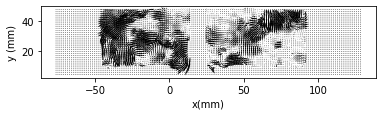

In [ ]:
graphics.quiver(data[dict(y=slice(100, 175))])
# something strange with the mask

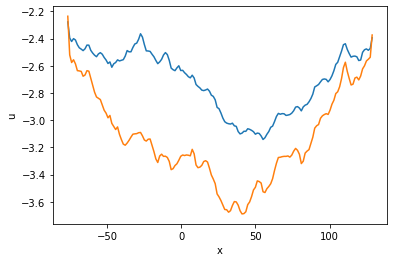

In [ ]:
# let's test homogeneity above the canopy: 
# take y above some value and .mean(dim='y')
# take mean with time .mean(dim='t')
# plot:
data.where(data.y>120,drop=True).mean(dim='t').mean(dim='y').u.plot()
data.where(data.y>150,drop=True).mean(dim='t').mean(dim='y').u.plot()

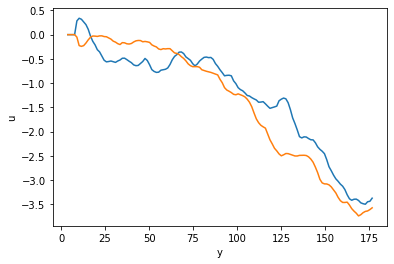

In [ ]:
data.where((data.x > -40) & (data.x < 0), drop=True).mean(dim='t').u.mean(dim='x').plot()
data.where((data.x > 20) & (data.x < 80), drop=True).mean(dim='t').u.mean(dim='x').plot()

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='x(mm)', ylabel='y (mm)'>)

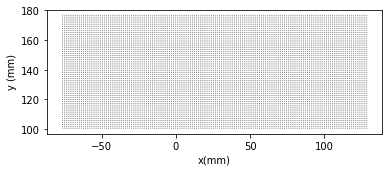

In [ ]:
graphics.quiver(data.where(data.y>100,drop=True).mean(dim='t'),units=['mm','mm','m/s','m/s'],arrScale=500)

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='x [mm]', ylabel='y [mm]'>)

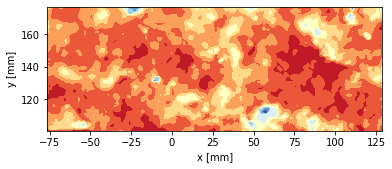

In [ ]:
# and some cool plot of average TKE above the canopy 
graphics.contour_plot(data.piv.tke().mean(dim='t').where(data.y > 100,drop=True),units=data.attrs['units'])